# Homework 07:  Topic Modeling with Latent Semantic Analysis

In [59]:
import numpy as np
import string
import math
from collections import Counter
import scipy.linalg as la
from scipy import stats
from scipy import cluster
from scipy import spatial
import matplotlib.pyplot as plt
import pickle

Latent Semantic Analysis (LSA) is a method for finding latent similarities between documents treated as a bag of words by using a low rank approximation. It is used for document classification, clustering and retrieval. For example, LSA can be used to search for prior art given a new patent application. In this homework, we will implement a small library for simple latent semantic analysis as a practical example of the application of SVD. The ideas are very similar to PCA. SVD is also used in recommender systems in an similar fashion (for an SVD-based recommender system library, see [Surpise](http://surpriselib.com)). 

We will implement a toy example of LSA to get familiar with the ideas. If you want to use LSA or similar methods for statistical language analysis, the most efficient Python libraries are probably [gensim](https://radimrehurek.com/gensim/) and [spaCy](https://spacy.io) - these also provide an online algorithm - i.e. the training information can be continuously updated. Other useful functions for processing natural language can be found in the [Natural Language Toolkit](http://www.nltk.org/).

**Note**: The SVD from scipy.linalg performs a full decomposition, which is inefficient since we only need to decompose until we get the first k singluar values. If the SVD from `scipy.linalg` is too slow, please use the `sparsesvd` function from the [sparsesvd](https://pypi.python.org/pypi/sparsesvd/) package to perform SVD instead.  You can install in the usual way with 
```
!pip install sparsesvd
```

Then import the following
```python
from sparsesvd import sparsesvd 
from scipy.sparse import csc_matrix 
```

and use as follows
```python
sparsesvd(csc_matrix(M), k=10)
```

**Exercise 1 (20 points)**.  Calculating pairwise distance matrices.

Suppose we want to construct a distance matrix between the rows of a matrix. For example, given the matrix 

```python
M = np.array([[1,2,3],[4,5,6]])
```

the distance matrix using Euclidean distance as the measure would be
```python
[[ 0.000  1.414  2.828]
 [ 1.414  0.000  1.414]
 [ 2.828  1.414  0.000]] 
```
if $M$ was a collection of column vectors.

Write a function to calculate the pairwise-distance matrix given the matrix $M$ and some arbitrary distance function. Your functions should have the following signature:
```
def func_name(M, distance_func):
    pass
```

0. Write a distance function for the Euclidean, squared Euclidean and cosine measures.
1. Write the function using looping for M as a collection of row vectors.
2. Write the function using looping for M as a collection of column vectors.
3. Write the function using broadcasting for M as a collection of row vectors.
4. Write the function using broadcasting for M as a collection of column vectors. 

For 3 and 4, try to avoid using transposition (but if you get stuck, there will be no penalty for using transposition).

We start by defining M exactly as it is in the instructions above (which makes it a collection of row vectors)

In [60]:
M = np.array([[1,2,3],[4,5,6]])
M

array([[1, 2, 3],
       [4, 5, 6]])

Write a distance function for the Euclidean, squared Euclidean, and cosine measures

In [4]:
def sq_euclid(v1, v2):
    """Calculate pairwise squared Euclidean distances between two input vectors"""
    return np.square(v1 - v2).sum()

In [5]:
def euclid(v1, v2):
    """Calculate pairwise Euclidean distances between two input vectors"""
    return np.sqrt(sq_euclid(v1, v2))

In [6]:
def cos_dist(v1, v2):
    return 1 - (v1 @ v2.T) / (np.linalg.norm(v1) * np.linalg.norm(v2))

Write the function using looping for M as a collection of row vectors

In [7]:
def part2(M, distance_func):
    """Compute specified distance metric between rows of M, where M is specified as a collection of row vectors"""
    result = np.zeros(shape = (M.shape[0], M.shape[0]))
    for i in range(M.shape[0]):
        for j in range(i + 1, M.shape[0]):
            result[i, j] = distance_func(M[i, :], M[j, :])
    return result + result.T

In [8]:
# Euclidean distance
print("Euclidean distance")
print(np.round(part2(M, euclid), decimals = 3))

# Squared euclidean distance
print("Squared euclidean distance")
print(np.round(part2(M, sq_euclid), decimals = 3))

# Cosine distance
print("Cosine distance")
print(np.round(part2(M, cos_dist), decimals = 3))

Euclidean distance
[[0.    5.196]
 [5.196 0.   ]]
Squared euclidean distance
[[ 0. 27.]
 [27.  0.]]
Cosine distance
[[0.    0.025]
 [0.025 0.   ]]


Write the function using looping for M as a collection of column vectors

*A solution using transposition* 

In [9]:
def part3(M, distance_func):
    """Compute specified distance metric between rows of M, where M is specified as a collection of column vectors"""
    return part2(M.T, distance_func)

In [10]:
# Euclidean distance
print("Euclidean distance")
print(np.round(part3(M, euclid), decimals = 3))

# Squared euclidean distance
print("Squared euclidean distance")
print(np.round(part3(M, sq_euclid), decimals = 3))

# Cosine distance
print("Cosine distance")
print(np.round(part3(M, cos_dist), decimals = 3))

Euclidean distance
[[0.    1.414 2.828]
 [1.414 0.    1.414]
 [2.828 1.414 0.   ]]
Squared euclidean distance
[[0. 2. 8.]
 [2. 0. 2.]
 [8. 2. 0.]]
Cosine distance
[[0.    0.009 0.024]
 [0.009 0.    0.003]
 [0.024 0.003 0.   ]]


*A solution without transposition*

In [11]:
def part3_2(M, distance_func):
    """Compute specified distance metric between rows of M, where M is specified as a collection of column vectors"""
    result = np.zeros(shape = (M.shape[1], M.shape[1]))
    for i in range(M.shape[1]):
        for j in range(i + 1, M.shape[1]):
            result[i, j] = distance_func(M[:, i], M[:, j])
    return result + result.T

In [12]:
# Euclidean distance
print("Euclidean distance")
print(np.round(part3_2(M, euclid), decimals = 3))

# Squared euclidean distance
print("Squared euclidean distance")
print(np.round(part3_2(M, sq_euclid), decimals = 3))

# Cosine distance
print("Cosine distance")
print(np.round(part3_2(M, cos_dist), decimals = 3))

Euclidean distance
[[0.    1.414 2.828]
 [1.414 0.    1.414]
 [2.828 1.414 0.   ]]
Squared euclidean distance
[[0. 2. 8.]
 [2. 0. 2.]
 [8. 2. 0.]]
Cosine distance
[[0.    0.009 0.024]
 [0.009 0.    0.003]
 [0.024 0.003 0.   ]]


Write the function using broadcasting for M as a collection of row vectors

In [13]:
test = (M[None, :] - M[:, None])
test

array([[[ 0,  0,  0],
        [ 3,  3,  3]],

       [[-3, -3, -3],
        [ 0,  0,  0]]])

In [14]:
test2 = (M.T[None, :] - M.T[:, None])
test2

array([[[ 0,  0],
        [ 1,  1],
        [ 2,  2]],

       [[-1, -1],
        [ 0,  0],
        [ 1,  1]],

       [[-2, -2],
        [-1, -1],
        [ 0,  0]]])

In [15]:
def part4(M, distance_func):
    """Compute specified distance metric between rows of M (using broadcasting), 
    
    where M is specified as a collection of column vectors"""
    
    # Calculate rows differences using broadcasting
    dists = M[None, :] - M[:, None]
    
    # Calculate specified distance matric
    result = np.zeros(shape = (M.shape[0], M.shape[0]))
    for i in range(dists.shape[0]):
        for j in range(i + 1, dists.shape[0]):
            result[i, j] = distance_func(dists[i, 0, :], dists[i, j, :])
    return result + result.T

In [16]:
# There's a bug for cos_dist
part4(M, cos_dist)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


array([[ 0., nan],
       [nan,  0.]])

In [17]:
np.round(np.sqrt(np.square(M.T[None, :] - M.T[:, None]).sum(axis = -1)), decimals = 3)

array([[0.   , 1.414, 2.828],
       [1.414, 0.   , 1.414],
       [2.828, 1.414, 0.   ]])

In [18]:
np.round(np.sqrt(np.square(M[None, :] - M[:, None]).sum(axis = -1)), decimals = 3)

array([[0.   , 5.196],
       [5.196, 0.   ]])

**Exercise 2 (20 points)**. Write 3 functions to calculate the term frequency (tf), the inverse document frequency (idf) and the product (tf-idf). Each function should take a single argument `docs`, which is a dictionary of (key=identifier, value=document text) pairs, and return an appropriately sized array. Convert '-' to ' ' (space), remove punctuation, convert text to lowercase and split on whitespace to generate a collection of terms from the document text.

- tf = the number of occurrences of term $i$ in document $j$
- idf = $\log \frac{n}{1 + \text{df}_i}$ where $n$ is the total number of documents and $\text{df}_i$ is the number of documents in which term $i$ occurs.

Print the table of tf-idf values for the following document collection

```
s1 = "The quick brown fox"
s2 = "Brown fox jumps over the jumps jumps jumps"
s3 = "The the the lazy dog elephant."
s4 = "The the the the the dog peacock lion tiger elephant"

docs = {'s1': s1, 's2': s2, 's3': s3, 's4': s4}
```

In [61]:
# Create dictionary for testing
s1 = "The quick brown fox"
s2 = "Brown fox jumps over the jumps jumps jumps"
s3 = "The the the lazy dog elephant."
s4 = "The the the the the dog peacock lion tiger elephant"

docs = {'s1': s1, 's2': s2, 's3': s3, 's4': s4}

In [80]:
def format_text(doc):
    """Formats text from a single document"""
    doc = doc.translate(str.maketrans('-', ' ')).lower()
    return doc.translate(str.maketrans('', '', string.punctuation)).split()

In [21]:
def calc_tf(docs):
    """Calculate term frequency for all documents in the input"""
    
    # Find all unique words in docs
    words = np.unique(format_text(str(list(docs.values()))))
    
    # Initialize output array and column counter
    result = np.zeros(shape = (len(words), len(list(docs.keys()))))
    col = 0
    
    # For each document, count words, and assign to tf-matrix
    for doc in docs:
        counted_words = Counter(format_text(docs[doc]))
        for word in counted_words.elements():
            row = np.where(words == word)
            result[row, col] = counted_words[word]
        col += 1
    
    # Return result
    return result

In [22]:
def calc_idf(docs):
    """Calculate inverse document frequency"""
    
    # Find all unique words in docs
    words = np.unique(format_text(str(list(docs.values()))))
    
    # Initialize output array
    df = np.zeros(len(words))
    
    # Determine number of documents in input
    n = len(list(docs.keys()))
    
    # Calculate df
    for doc in docs:
        words_unique = np.unique(format_text(docs[doc]))
        for word in words_unique:
            index = np.where(words == word)
            df[index] += 1
    
    # Return idf
    return (np.log(n / (1 + df))).reshape(-1, 1)

In [23]:
def calc_tf_idf(docs):
    """Calculate tf-idf, given input documents"""
    return calc_tf(docs) * calc_idf(docs)

*At this point, I display the results of the 3 requested functions on the given dictionary of documents*

In [24]:
calc_tf(docs)

array([[1., 1., 0., 0.],
       [0., 0., 1., 1.],
       [0., 0., 1., 1.],
       [1., 1., 0., 0.],
       [0., 4., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 1., 3., 5.],
       [0., 0., 0., 1.]])

In [25]:
calc_idf(docs)

array([[ 0.28768207],
       [ 0.28768207],
       [ 0.28768207],
       [ 0.28768207],
       [ 0.69314718],
       [ 0.69314718],
       [ 0.69314718],
       [ 0.69314718],
       [ 0.69314718],
       [ 0.69314718],
       [-0.22314355],
       [ 0.69314718]])

In [26]:
calc_tf_idf(docs)

array([[ 0.28768207,  0.28768207,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.28768207,  0.28768207],
       [ 0.        ,  0.        ,  0.28768207,  0.28768207],
       [ 0.28768207,  0.28768207,  0.        ,  0.        ],
       [ 0.        ,  2.77258872,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.69314718,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.69314718],
       [ 0.        ,  0.69314718,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.69314718],
       [ 0.69314718,  0.        ,  0.        ,  0.        ],
       [-0.22314355, -0.22314355, -0.66943065, -1.11571776],
       [ 0.        ,  0.        ,  0.        ,  0.69314718]])

**Exercise 3 (20 points)**. 

1. Write a function that takes a matrix $M$ and an integer $k$ as arguments, and reconstructs a reduced matrix using only the $k$ largest singular values. Use the `scipy.linagl.svd` function to perform the decomposition. This is the least squares approximation to the matrix $M$ in $k$ dimensions.

2. Apply the function you just wrote to the following term-frequency matrix for a set of $9$ documents using $k=2$ and print the reconstructed matrix $M'$.
```
M = np.array([[1, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 1, 0, 0, 0, 0],
       [0, 1, 1, 2, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1]])
```

3. Calculate the pairwise correlation matrix for the original matrix M and the reconstructed matrix using $k=2$ singular values (you may use [scipy.stats.spearmanr](http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html) to do the calculations). Consider the first 5 sets of documents as one group $G1$ and the last 4 as another group $G2$ (i.e. first 5 and last 4 columns). What is the average within group correlation for $G1$, $G2$ and the average cross-group correlation for G1-G2 using either $M$ or $M'$. (Do not include self-correlation in the within-group calculations.).

Write a function that takes a matrix, `M`, and an integer, `k`, and reconstructs a reduced matrix using only the `k` largest singular values

In [27]:
def reduced_matrix(M, k):
    """Returns reduced matrix using only k largest singular values of M"""
    U, s, Vt = la.svd(M, full_matrices = False)
    return U[:, :k] @ np.diag(s[:k]) @ Vt[:k, :]

Apply the function to the provided `M` using k = 2, and print the resulting `M'`

In [28]:
# Given matrix, M
M = np.array([[1, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 1, 0, 0, 0, 0],
       [0, 1, 1, 2, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1]])

# Print M'
M_prime = reduced_matrix(M, 2)
np.round(M_prime, decimals = 3)

array([[ 0.162,  0.4  ,  0.379,  0.468,  0.176, -0.053, -0.115, -0.159,
        -0.092],
       [ 0.141,  0.37 ,  0.329,  0.4  ,  0.165, -0.033, -0.071, -0.097,
        -0.043],
       [ 0.152,  0.505,  0.358,  0.41 ,  0.236,  0.024,  0.06 ,  0.087,
         0.124],
       [ 0.258,  0.841,  0.606,  0.697,  0.392,  0.033,  0.083,  0.122,
         0.187],
       [ 0.449,  1.234,  1.051,  1.266,  0.556, -0.074, -0.155, -0.21 ,
        -0.049],
       [ 0.16 ,  0.582,  0.375,  0.417,  0.277,  0.056,  0.132,  0.189,
         0.217],
       [ 0.16 ,  0.582,  0.375,  0.417,  0.277,  0.056,  0.132,  0.189,
         0.217],
       [ 0.218,  0.55 ,  0.511,  0.628,  0.243, -0.065, -0.143, -0.197,
        -0.108],
       [ 0.097,  0.532,  0.23 ,  0.212,  0.267,  0.137,  0.315,  0.444,
         0.425],
       [-0.061,  0.232, -0.139, -0.266,  0.145,  0.24 ,  0.546,  0.767,
         0.664],
       [-0.065,  0.335, -0.146, -0.301,  0.203,  0.306,  0.695,  0.977,
         0.849],
       [-0.043,  0.25

Next, I calculate a pairwise correlation matrix between the columns of (1) M and (2) M'. For each of the resulting correlation matrices, I then calculate the 3 requested metrics: average within group correlation for G1, average within group correlation for G2, and average cross-group correlation between G1 and G2

*Reference for excluding diagonal from average: https://stackoverflow.com/questions/62250799/mean-of-non-diagonal-elements-of-each-row-numpy*

In [29]:
# Calculate pairwise correlation matrix using original matrix, M
M_corr = stats.spearmanr(M, axis = 0)[0]
print("All values below are for original matrix, M")

# Find average within group correlation for G1 (documents 1-5)
G1 = M_corr[0:5, 0:5]
weights = np.ones(shape = G1.shape)
np.fill_diagonal(weights, 0)
G1_corr = np.average(G1, weights = weights)
print("G1 average within group correlation: " + str(np.round(G1_corr, decimals = 3)))

# Find average within group correlation for G2 (documents 6-9)
G2 = M_corr[5:9, 5:9]
weights = np.ones(shape = G2.shape)
np.fill_diagonal(weights, 0)
G2_corr = np.average(G2, weights = weights)
print("G2 average within group correlation: " + str(np.round(G2_corr, decimals = 3)))

# Find average cross-group correlation for G1-G2
cross_group = M_corr[0:5, 5:9]
cross_group_corr = cross_group.mean()
print("Average cross-group correlation between G1 and G2: " + str(np.round(cross_group_corr, decimals = 3)))

All values below are for original matrix, M
G1 average within group correlation: 0.011
G2 average within group correlation: 0.435
Average cross-group correlation between G1 and G2: -0.308


In [30]:
# Calculate pairwise correlation matrix M'
M_prime_corr = stats.spearmanr(M_prime, axis = 0)[0]
print("All values below are for M'")

# Find average within group correlation for G1 (documents 1-5)
G1 = M_prime_corr[0:5, 0:5]
weights = np.ones(shape = G1.shape)
np.fill_diagonal(weights, 0)
G1_corr = np.average(G1, weights = weights)
print("G1 average within group correlation: " + str(np.round(G1_corr, decimals = 3)))

# Find average within group correlation for G2 (documents 6-9)
G2 = M_prime_corr[5:9, 5:9]
weights = np.ones(shape = G2.shape)
np.fill_diagonal(weights, 0)
G2_corr = np.average(G2, weights = weights)
print("G2 average within group correlation: " + str(np.round(G2_corr, decimals = 3)))

# Find average cross-group correlation for G1-G2
cross_group = M_prime_corr[0:5, 5:9]
cross_group_corr = cross_group.mean()
print("Average cross-group correlation between G1 and G2: " + str(np.round(cross_group_corr, decimals = 3)))

All values below are for M'
G1 average within group correlation: 0.865
G2 average within group correlation: 0.99
Average cross-group correlation between G1 and G2: -0.677


In case it's helpful, I'll also print out the pointwise correlation matrices for M and M'.

In [66]:
print("Correlation matrix for M")
print(M_corr)
print("\nCorrelation for M'")
print(M_prime_corr)

Correlation matrix for M
[[ 1.         -0.19245009  0.          0.07339758 -0.33333333 -0.17407766
  -0.25819889 -0.33333333 -0.33333333]
 [-0.19245009  1.          0.         -0.12712835  0.57735027 -0.30151134
  -0.4472136  -0.57735027 -0.19245009]
 [ 0.          0.          1.          0.43822991  0.         -0.21320072
  -0.31622777 -0.40824829 -0.40824829]
 [ 0.07339758 -0.12712835  0.43822991  1.         -0.33028913 -0.17248787
  -0.25584086 -0.33028913 -0.33028913]
 [-0.33333333  0.57735027  0.         -0.33028913  1.         -0.17407766
  -0.25819889 -0.33333333 -0.33333333]
 [-0.17407766 -0.30151134 -0.21320072 -0.17248787 -0.17407766  1.
   0.67419986  0.52223297 -0.17407766]
 [-0.25819889 -0.4472136  -0.31622777 -0.25584086 -0.25819889  0.67419986
   1.          0.77459667  0.25819889]
 [-0.33333333 -0.57735027 -0.40824829 -0.33028913 -0.33333333  0.52223297
   0.77459667  1.          0.55555556]
 [-0.33333333 -0.19245009 -0.40824829 -0.33028913 -0.33333333 -0.17407766
   0.

This large difference in results begs the question of whether M is well approximated by its rank 2 approximation. Below, I show that it is not well approximated in 2 ways: (1) by showing that the first two singular values contain only about 40% of the total information in M and (2) plotting M and M' to visually see the difference

In [31]:
# Perform SVD, and look at cumulative sum of singular values
U, s, Vt = la.svd(M, full_matrices = False)
s.cumsum() / s.sum()

array([0.23101137, 0.40676182, 0.56952945, 0.68324357, 0.78729783,
       0.87762994, 0.93612142, 0.97485292, 1.        ])

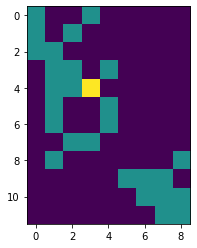

In [32]:
plt.imshow(M);

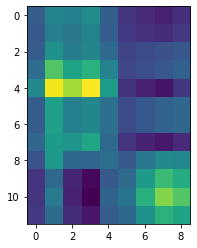

In [33]:
plt.imshow(M_prime);

**Exercise 4 (40 points)**. Clustering with LSA

1. Begin by loading a PubMed database of selected article titles using 'pickle'. With the following:
```import pickle
docs = pickle.load(open('pubmed.pic', 'rb'))```

    Create a tf-idf matrix for every term that appears at least once in any of the documents. What is the shape of the tf-idf matrix? 

2. Perform SVD on the tf-idf matrix to obtain $U \Sigma V^T$ (often written as $T \Sigma D^T$ in this context with $T$ representing the terms and $D$ representing the documents). If we set all but the top $k$ singular values to 0, the reconstructed matrix is essentially $U_k \Sigma_k V_k^T$, where $U_k$ is $m \times k$, $\Sigma_k$ is $k \times k$ and $V_k^T$ is $k \times n$. Terms in this reduced space are represented by $U_k \Sigma_k$ and documents by $\Sigma_k V^T_k$. Reconstruct the matrix using the first $k=10$ singular values.

3. Use agglomerative hierarchical clustering with complete linkage to plot a dendrogram and comment on the likely number of  document clusters with $k = 100$. Use the dendrogram function from [SciPy ](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

4. Determine how similar each of the original documents is to the new document `data/mystery.txt`. Since $A = U \Sigma V^T$, we also have $V = A^T U \Sigma^{-1}$ using orthogonality and the rule for transposing matrix products. This suggests that in order to map the new document to the same concept space, first find the tf-idf vector $v$ for the new document - this must contain all (and only) the terms present in the existing tf-idx matrix. Then the query vector $q$ is given by $v^T U_k \Sigma_k^{-1}$. Find the 10 documents most similar to the new document and the 10 most dissimilar. 

First, I load the data using the provided command

In [81]:
docs = pickle.load(open('pubmed.pic', 'rb'))

Next, I create the tf-idf matrix, and display the shape (6638 unique words across 178 documents). We should note that exercise 2 does not ask us to remove numbers from the text. As a result, the first approximately 500 "words" are comprised of numbers (or mixes of numbers and letters that have been created by removing punctuation). There are also some odd words scattered throughout, which are also likely generated by the removal of punctuation (e.g., clinicaltrialsgov probably came from clinicaltrials.gov)

In [83]:
tf_idf = calc_tf_idf(docs)
tf_idf.shape

(6637, 178)

In [82]:
words = np.unique(format_text(str(list(docs.values()))))
words

array(['0', '0000028', '00001', ..., 'youths', 'zno', 'zoo'], dtype='<U34')

Reconstruct the tf-idf matrix using the top 10 singular values

In [38]:
tf_idf_10 = reduced_matrix(M = tf_idf, k = 10)
tf_idf_10

array([[ 1.27651297e+01,  6.50508560e-01,  9.48719245e-01, ...,
         4.44973423e-01,  6.92467824e-01,  5.43981584e-01],
       [ 2.17842954e-01,  1.41243614e-01,  5.94068640e-02, ...,
        -1.97148752e-01,  5.05747708e-02,  5.33439642e-02],
       [-7.39637963e-03,  2.76897067e-02,  1.44250313e-02, ...,
         7.55320560e-02,  1.34844436e-02,  5.47959009e-03],
       ...,
       [-1.01436457e-02,  1.78831325e-02,  1.50992739e-02, ...,
         1.08518488e-02,  4.95277497e-03,  8.17562554e-03],
       [-9.81673124e-02,  1.11974862e-01,  8.33459083e-02, ...,
         1.56032355e-01,  4.18909107e-02,  4.03409089e-02],
       [-6.49299485e-03,  2.50270712e-02,  1.90722676e-02, ...,
         2.02162619e-02,  7.64046063e-03,  9.90444450e-03]])

Use agglomerative hierarchical clustering with complete linkage to plot a dendrogram and comment on the likely number of document clusters with  k=100. TALK ABOUT USING JUST THE DOCUMENT-SPECIFIC FEATURES $\Sigma_kV_k^T$ (or maybe not... can try both)

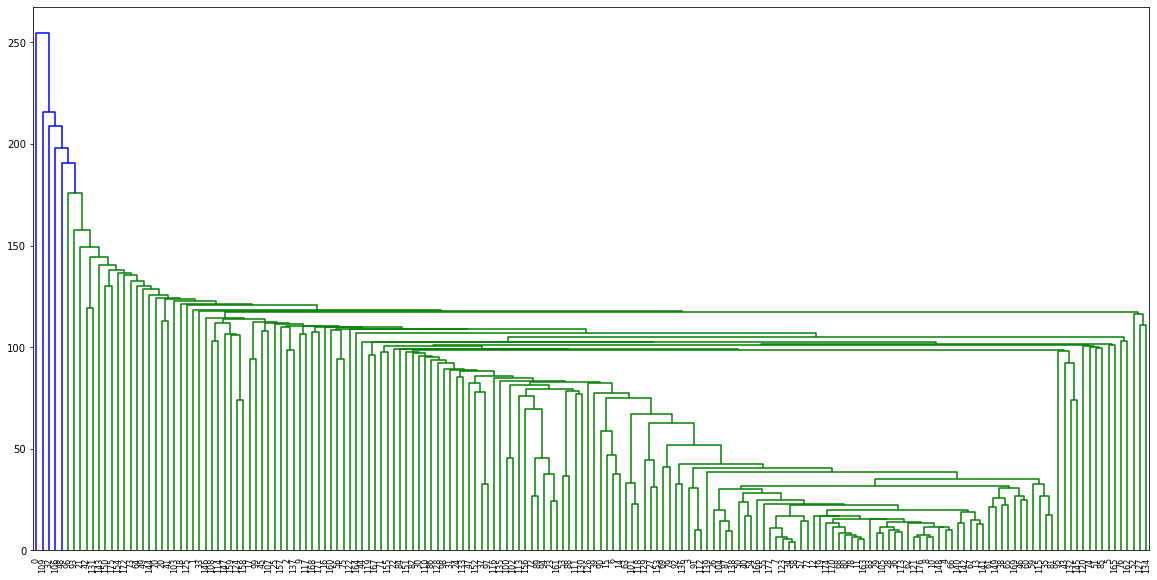

In [58]:
# Reconstruct tf-idf matrix using the top 100 singular values
tf_idf_100 = reduced_matrix(M = tf_idf, k = 100)

# Plot the dendrogram
Z = cluster.hierarchy.linkage(tf_idf_100.T, method = 'complete')
plt.figure(figsize=(20, 10));
cluster.hierarchy.dendrogram(Z, leaf_rotation = 90., leaf_font_size = 8); #, color_threshold = 100);

**TALK ABOUT NUMBER OF CLUSTERS OBSERVED**

Determine how similar each of the original documents is to the new document `data/mystery.txt`.

**Notes on the Pubmed articles**

These were downloaded with the following script.

```python
from Bio import Entrez, Medline
Entrez.email = "YOUR EMAIL HERE"
import cPickle

try:
    docs = cPickle.load(open('pubmed.pic'))
except Exception, e:
    print e

    docs = {}
    for term in ['plasmodium', 'diabetes', 'asthma', 'cytometry']:
        handle = Entrez.esearch(db="pubmed", term=term, retmax=50)
        result = Entrez.read(handle)
        handle.close()
        idlist = result["IdList"]
        handle2 = Entrez.efetch(db="pubmed", id=idlist, rettype="medline", retmode="text")
        result2 = Medline.parse(handle2)
        for record in result2:
            title = record.get("TI", None)
            abstract = record.get("AB", None)
            if title is None or abstract is None:
                continue
            docs[title] = '\n'.join([title, abstract])
            print title
        handle2.close()
    cPickle.dump(docs, open('pubmed.pic', 'w'))
docs.values()
```